In [1]:
from fastai.vision.all import *
from fastai.vision.gan import * 

In [2]:
path_hr = Path('/kaggle/input/colorful-images/kaggle/working/new')
path_lr = Path('/kaggle/input/oldified-images/kaggle/working/old1')

In [3]:
items = get_image_files(path_hr)
bad_im = get_image_files(path_lr)

In [4]:
im1 = PILImage.create(items[45])
im2 = PILImage.create(bad_im[45])

<AxesSubplot:>

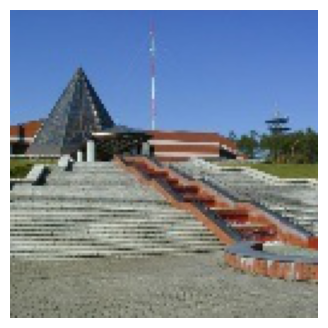

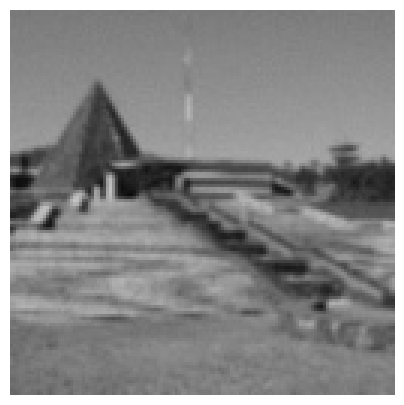

In [5]:
im1.show(); im2.show(figsize=(5,5))

In [6]:
def get_dls(bs:int, size:int):
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(size),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                   Normalize.from_stats(*imagenet_stats)])
    dls = dblock.dataloaders(path_lr, bs=bs, device=torch.device('cuda'))
    dls.c = 3 # For 3 channel image
    return dls

In [7]:
dls_gen = get_dls(32, 128)

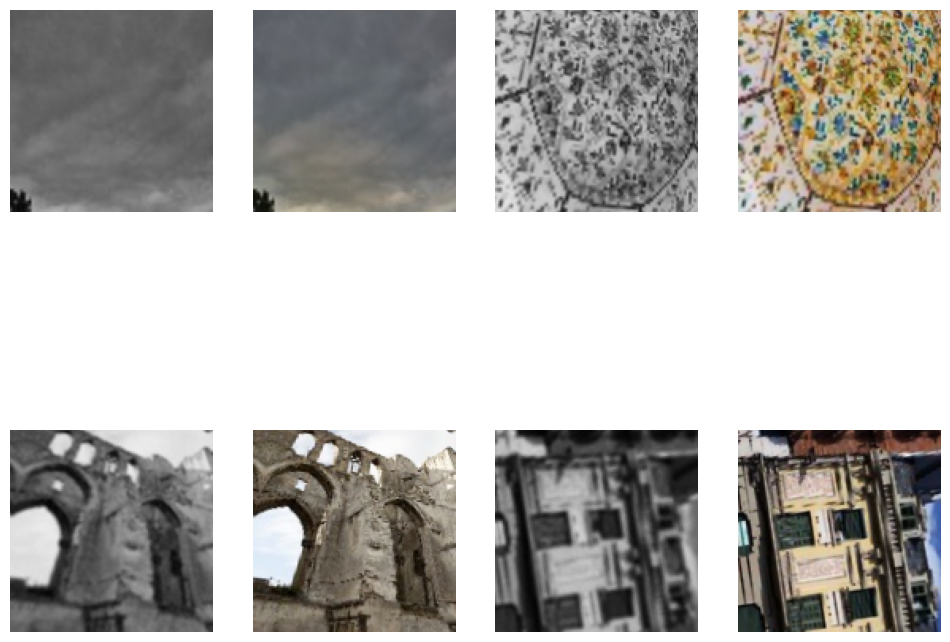

In [8]:
dls_gen.show_batch(max_n=4, figsize=(12,10))

In [9]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [10]:
bbone = resnet34
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen,
                        blur=True, norm_type=NormType.Weight, self_attention=True,y_range=y_range)

In [11]:
learn_gen = create_gen_learner()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [12]:
# learn_gen.fit_one_cycle(10, pct_start=0.8, wd=wd)

In [13]:
# learn_gen.unfreeze()


In [14]:
# learn_gen.fit_one_cycle(10, slice(1e-6,1e-3), wd=wd)


In [15]:
# learn_gen.show_results(max_n=4, figsize=(12,12))


In [16]:
# learn_gen.save('gen-pre2')


In [17]:
learn_gen.load('/kaggle/input/generator-model/gen-pre2 (1)')

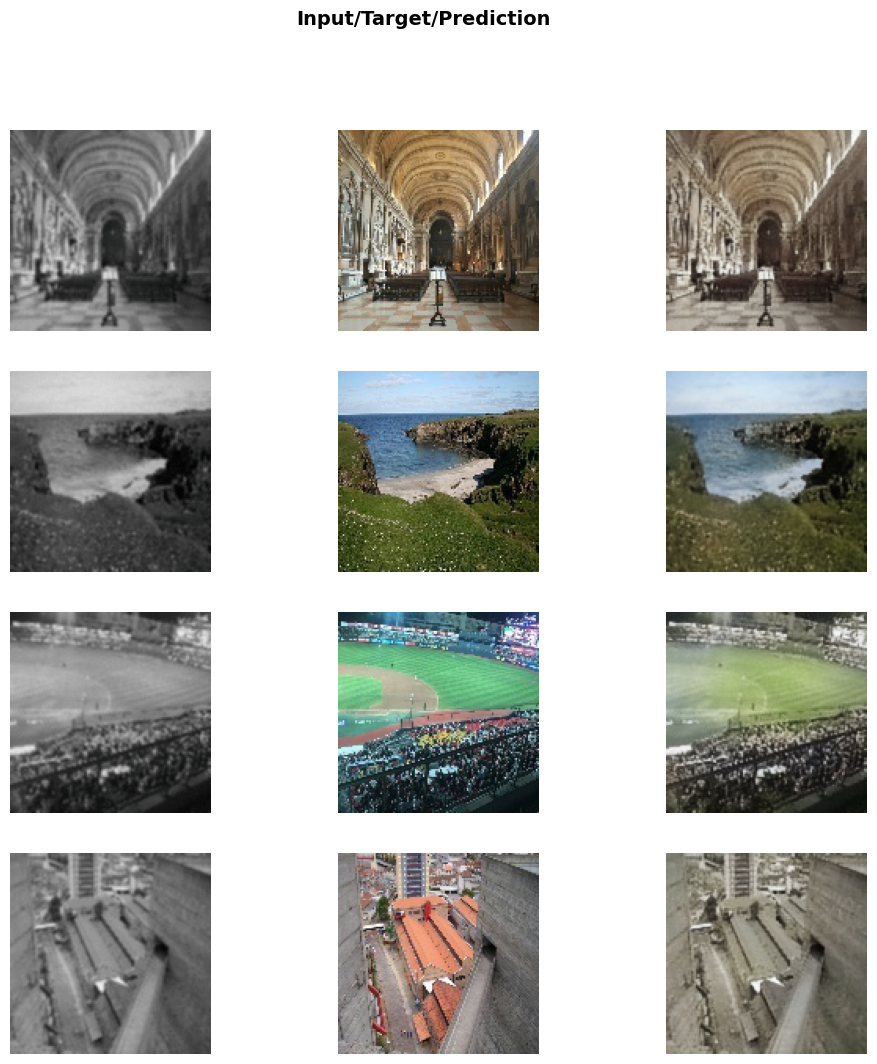

In [18]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [19]:
import gc 
gc.collect()

38286

In [20]:
path = Path('/kaggle/working/')
name_gen = 'image_gen'
path_gen = path/name_gen
path_gen.mkdir(exist_ok=True)
device = 'cuda'
default_device(use=True)

device(type='cuda', index=0)

In [23]:
from torch.utils.checkpoint import checkpoint

def get_preds_with_checkpoint(dl, learn):
    preds = []
    for xb in dl:
        with torch.no_grad():
            # use checkpoint to reduce memory usage
            pred = checkpoint(learn.model, xb[0])
            preds.append(pred)
    return preds



In [24]:
def save_preds(dl, preds):

    names = dl.dataset.items
    count = 0
    
    for i,pred in enumerate(preds):
        for j in range(len(pred)):            
            dec = dl.after_batch.decode((TensorImage(pred[j][None]).cpu(),))[0][0]
            arr = dec.numpy().transpose(1,2,0).astype(np.uint8)
            Image.fromarray(arr).save(path_gen/names[count].name)
            count=count+1

In [25]:
dl = dls_gen.train.new(shuffle=False, drop_last=False, 
                       after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)],device=torch.device('cuda'))

In [26]:
del dls_gen , bad_im
gc.collect()

46

In [27]:
# preds = get_preds_with_checkpoint(dl , learn_gen)

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [28]:
# save_preds(dl, preds)

In [29]:
# !zip -r gen.zip /kaggle/working/image_gen

  adding: kaggle/working/image_gen/ (stored 0%)
  adding: kaggle/working/image_gen/image3239.jpg (deflated 4%)
  adding: kaggle/working/image_gen/image29237.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image2152.jpg (deflated 4%)
  adding: kaggle/working/image_gen/image0668.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image17565.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image16635.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image30862.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image23552.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image10111.jpg (deflated 2%)
  adding: kaggle/working/image_gen/image21687.jpg (deflated 4%)
  adding: kaggle/working/image_gen/image26425.jpg (deflated 5%)
  adding: kaggle/working/image_gen/image28281.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image26891.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image17368.jpg (deflated 3%)
  adding: kaggle/working/image_gen/image14010.jpg (deflated

In [ ]:
path_gen = Path('/kaggle/input/generated-images/kaggle/working/image_gen')

In [30]:
path_g = get_image_files(path_gen)
path_i = get_image_files(path_hr)
fnames = path_g + path_i

In [31]:
def get_crit_dls(fnames, bs:int, size:int):
    splits = RandomSplitter(0.1)(fnames)
    dsrc = Datasets(fnames, tfms=[[PILImage.create], [parent_label, Categorize]],
                 splits=splits)
    tfms = [ToTensor(), Resize(size)]
    gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
    return dsrc.dataloaders(bs=bs, after_item=tfms, after_batch=gpu_tfms)

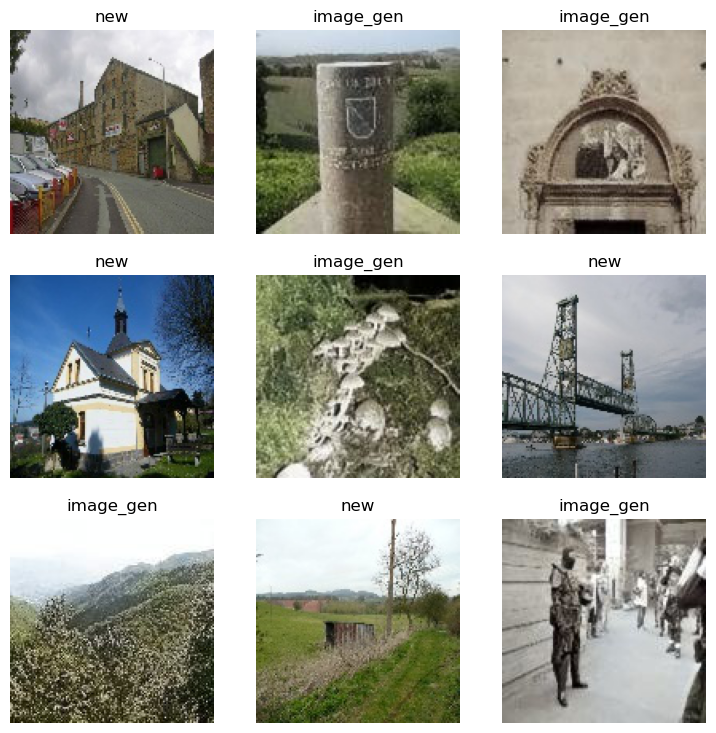

In [32]:
dls_crit = get_crit_dls(fnames, bs=32, size=128)
dls_crit.show_batch()
loss_crit = AdaptiveLoss(nn.BCEWithLogitsLoss())


In [33]:
def create_crit_learner(dls, metrics):
    return Learner(dls, gan_critic(), metrics=metrics, loss_func=loss_crit)

In [34]:
learn_crit = create_crit_learner(dls_crit, accuracy_thresh_expand)


In [ ]:
# learn_crit.fit_one_cycle(6, 1e-3, wd=wd)


In [ ]:
# learn_crit.save('critic-pre2')


In [35]:
ls_crit = get_crit_dls(fnames, bs=32, size=128)

In [37]:
dls_gen = get_dls(32,128)

In [38]:
learn_crit = create_crit_learner(dls_crit, metrics=None).load('/kaggle/input/critic-and-gan-model/critic-pre2')
learn_gen = create_gen_learner().load('/kaggle/input/generator-model/gen-pre2 (1)')

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
class GANDiscriminativeLR(Callback):
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [40]:
switcher = AdaptiveGANSwitcher(critic_thresh=.1)


In [41]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [42]:
lr = 1e-4

In [43]:
# learn.fit(10, lr, wd=wd)

In [44]:
# learn.save('gan-pre2')

In [45]:
learn.load('/kaggle/input/critic-and-gan-model/gan-pre2')

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:58: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


/opt/conda/lib/python3.7/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/opt/conda/lib/python3.7/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/opt/conda/lib/python3.7/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


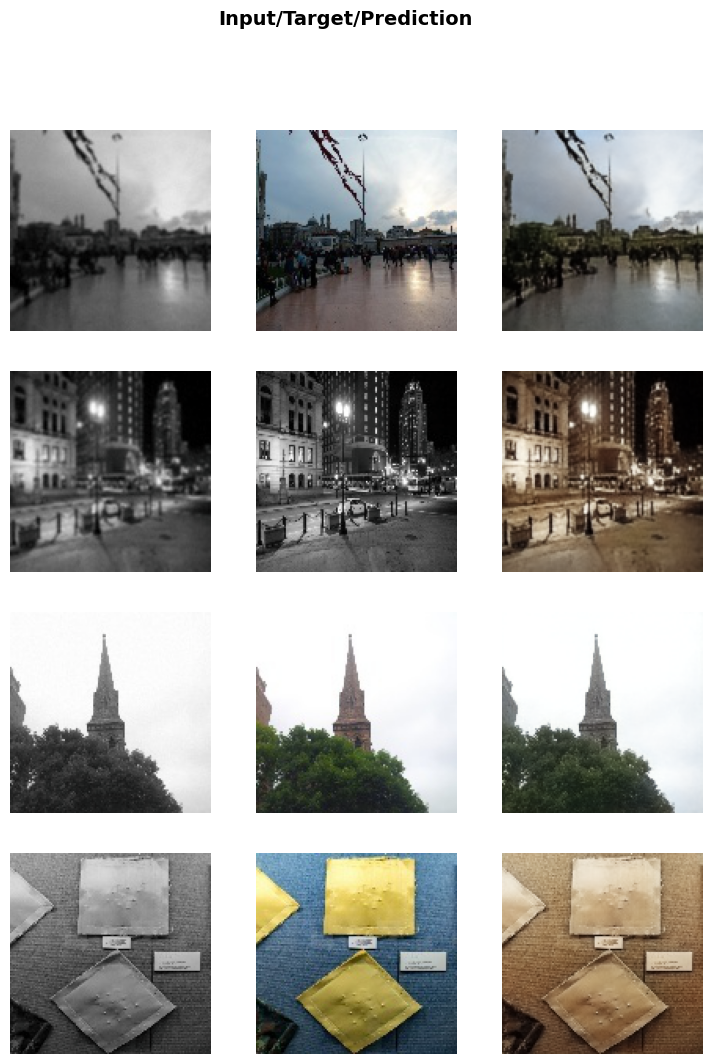

In [48]:
learn.show_results(max_n=4)


In [54]:
def deoldify(path) :
    import matplotlib.pyplot as plt
    img = plt.imread(path)
    pred = learn.predict(img)
    dec = dl.after_batch.decode((TensorImage(pred[2][None]).cpu(),))[0][0]
    arr = dec.numpy().transpose(1,2,0)
    
    fig=plt.figure(figsize=(8, 8))
    fig.add_subplot(1,2,1)
    plt.imshow(img)
    fig.add_subplot(1,2,2)
    plt.imshow(arr)
    plt.show()

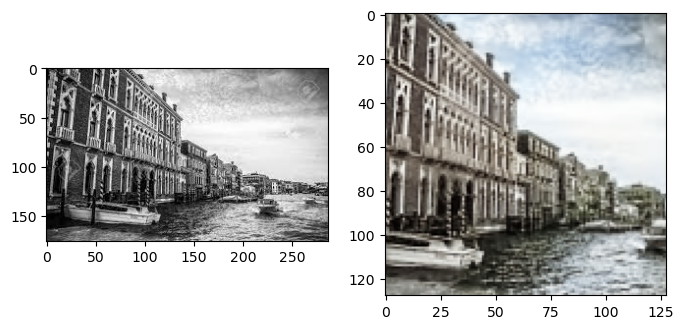

In [59]:
path = '/kaggle/input/testing-imagesold/images.jpg'
deoldify(path)